<a href="https://colab.research.google.com/github/bmeelnlga/myportfolio/blob/main/Model_Training__Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Download the **MIT-BIH Arrhythmia dataset** from Kaggle. https://www.kaggle.com/datasets/shayanfazeli/heartbeat

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heartbeat


Step 2: Data preprocessing (If applicable)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 讀取數據
train_df = pd.read_csv(f"{path}/mitbih_train.csv", header=None)
test_df = pd.read_csv(f"{path}/mitbih_test.csv", header=None)

# 提取 X (特徵) 和 y (標籤)
X_train, y_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
X_test, y_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

# 標準化 ECG 訊號 (縮放至 [0,1])
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# One-hot 編碼
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# 訓練集與測試集的形狀
print(f"訓練集: {X_train.shape}, 測試集: {X_test.shape}")


訓練集: (87554, 187), 測試集: (21892, 187)


Step 3: Building model (5 classes)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# 建立 CNN 模型
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation="relu"),
    Conv1D(filters=256, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),  # 防止過擬合
    Dense(5, activation="softmax")  # 五個類別
])

# 編譯模型
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 顯示模型架構
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 183, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 39, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4864)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       622,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,261 (3.66 MB)

 Trainable params: 960,261 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Step 4: Model training and save model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 設定 EarlyStopping，當驗證損失不再改善時停止訓練
early_stopping = EarlyStopping(monitor="val_f1_score", patience=10,mode="max", restore_best_weights=True)

# 訓練模型
history = model.fit(
  X_train, y_train,
  epochs=50, batch_size=16,
  validation_split=0.1,
  callbacks=[early_stopping]
)

# 保存模型
model.save("ecg_classification_model.h5")
print("模型已保存！")

Epoch 1/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 266s 54ms/step - accuracy: 0.9494 - loss: 0.2005 - val_accuracy: 0.1704 - val_loss: 18.1639
Epoch 2/50
   2/4925 ━━━━━━━━━━━━━━━━━━━━ 5:42 69ms/step - accuracy: 0.9531 - loss: 0.3511

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


4925/4925 ━━━━━━━━━━━━━━━━━━━━ 264s 54ms/step - accuracy: 0.9794 - loss: 0.0763 - val_accuracy: 0.1718 - val_loss: 26.3302
Epoch 3/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 266s 54ms/step - accuracy: 0.9843 - loss: 0.0566 - val_accuracy: 0.1746 - val_loss: 32.3875
Epoch 4/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 325s 55ms/step - accuracy: 0.9853 - loss: 0.0521 - val_accuracy: 0.1807 - val_loss: 43.9407
Epoch 5/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 325s 55ms/step - accuracy: 0.9861 - loss: 0.0479 - val_accuracy: 0.1851 - val_loss: 56.0687
Epoch 6/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 320s 55ms/step - accuracy: 0.9878 - loss: 0.0429 - val_accuracy: 0.1790 - val_loss: 47.0171
Epoch 7/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 269s 55ms/step - accuracy: 0.9888 - loss: 0.0384 - val_accuracy: 0.1852 - val_loss: 53.1566
Epoch 8/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 344s 59ms/step - accuracy: 0.9890 - loss: 0.0385 - val_accuracy: 0.1855 - val_loss: 64.8436
Epoch 9/50
4925/4925 ━━━━━━━━━━━━━━━━━━━━ 307s 56ms/step - accuracy: 0.98

模型已保存！


Step 5: Output confusion matrix

685/685 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step


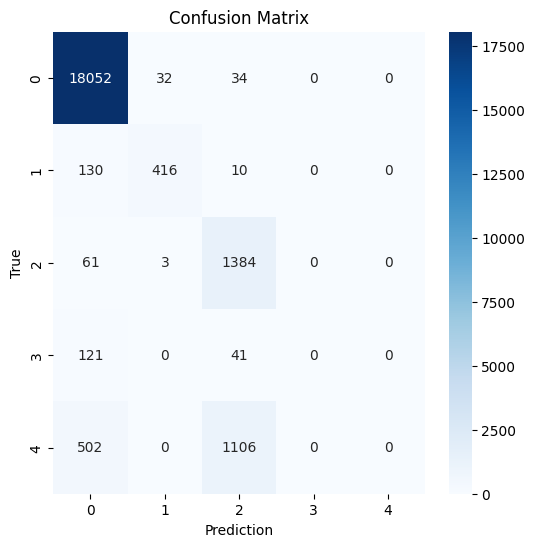

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 預測測試集
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)

# 繪製混淆矩陣
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Step 6: Output **Recall, Specificity, Precision, and F1 score** of each classes and a total **Accuracy**.

In [ ]:
from sklearn.metrics import classification_report

# 計算 Recall、Precision、F1-score、Accuracy
report = classification_report(y_true, y_pred_classes, target_names=["N", "S", "V", "F", "Q"])
print(report)

# 計算 Specificity
tn = np.diag(cm)  # 真負例
fp = np.sum(cm, axis=0) - tn  # 偽陽性
fn = np.sum(cm, axis=1) - tn  # 偽陰性
tp = np.sum(cm) - (fp + fn + tn)  # 真陽性

specificity = tn / (tn + fp)  # Specificity 計算公式
average_specificity = np.mean(specificity)

print(f"平均 Specificity: {average_specificity:.2%}")


              precision    recall  f1-score   support

           N       0.96      1.00      0.98     18118
           S       0.92      0.75      0.83       556
           V       0.54      0.96      0.69      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.91     21892
   macro avg       0.48      0.54      0.50     21892
weighted avg       0.85      0.91      0.87     21892

平均 Specificity: nan%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-6-2ea7b606ecf8>:13: RuntimeWarning